In [278]:
import pandas as pd 
import matplotlib.pyplot as plt 
import math
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np


sns.set()

In [279]:
df = pd.read_csv('Nat_Gas.csv', index_col='Dates', date_format='%m/%d/%y')
df.head(5)

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-10-31 to 2024-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prices  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


## Price of Natural Gas over Time

Text(0, 0.5, 'Price of Gas')

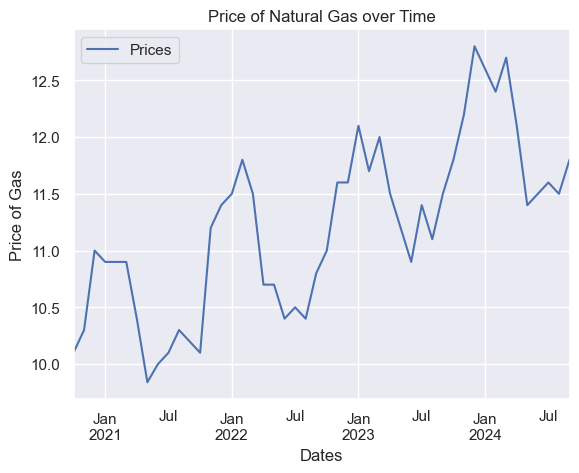

In [281]:
df.plot()
plt.title('Price of Natural Gas over Time')
plt.ylabel('Price of Gas')

## Seasonality (Multiplicative)

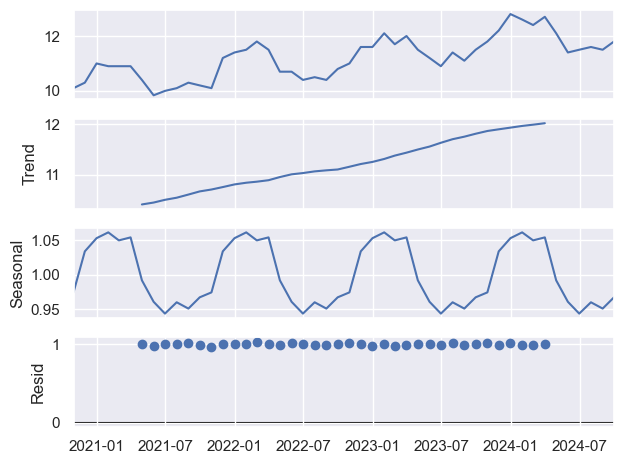

In [282]:
decompose_mult = seasonal_decompose(df, model="multiplicative")
decompose_mult.plot();

## Price Forecasting

### Training Model

In [283]:
train = df[df.index < pd.to_datetime("2023-12-31", format='%Y-%m-%d')]
test = df[df.index >= pd.to_datetime("2023-12-31", format='%Y-%m-%d')]


In [284]:
y = train['Prices']
SARIMAXmodel = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1,1,1,12))
SARIMAXmodel = SARIMAXmodel.fit()

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


### Predictions and Evalutaions of Given Data

In [285]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha=0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

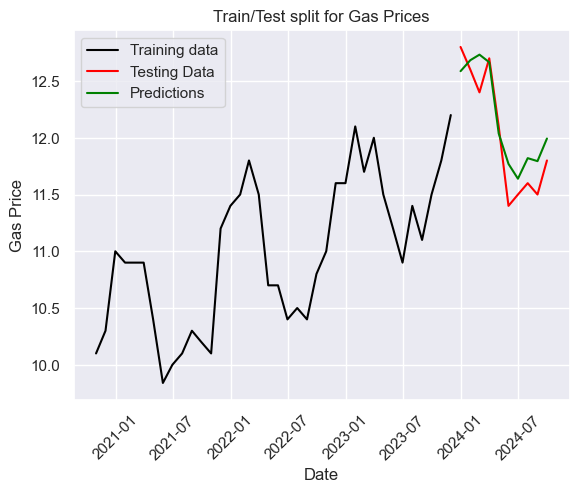

In [286]:
plt.plot(train, color = "black", label='Training data')
plt.plot(test, color = "red", label='Testing Data')
plt.ylabel('Gas Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Gas Prices")
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

In [287]:
sarimax_rmse = np.sqrt(mean_squared_error(test["Prices"].values, y_pred_df["Predictions"]))
print("RMSE: ", sarimax_rmse)

RMSE:  0.22282784622807397


### Future Forecasting

In [294]:
# Date = input("Input date in YYYY/MM format")

# YYYY/MM format (to bypass input everyime)
# Will predict price at end of month
Date = "2026/8"

SARIMAXmodel.predict(Date)

2026-08-31    12.920992
Freq: M, dtype: float64

## Pricing Prototype

In [289]:
ANNUAL_INTEREST_RATE = 0

def month_diff(a, b):
    return 12 * (a.year - b.year) + (a.month - b.month)

def pricing_prototype(buy_date, sell_date, buy_price, sell_price, max_vol, injection_fee, storage_cost, transport_cost=0):

    months = month_diff(sell_date, buy_date)

    costs = injection_fee + (storage_cost * months) + transport_cost
    pre_discounted_profit = (sell_price - buy_price) * max_vol + costs
    discounted_profit = pre_discounted_profit / ((1 + ANNUAL_INTEREST_RATE)**((months / 12)))
    return round(discounted_profit, 2)

In [290]:
estimate = pricing_prototype(buy_date=df.iloc[-1].name, sell_date=df.iloc[-4].name, buy_price=2, sell_price=3, max_vol=1e6, injection_fee=1e4, storage_cost=1e5, transport_cost=0)
'${:,.2f}'.format(estimate)

'$710,000.00'